In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy
from scipy.integrate import odeint
import math as m
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error


In [2]:
#We choose to convert the .csv file to .xls format and use pandas to parse it:
data = pd.ExcelFile("COVID19_Data_Spain.xls")
sheetX = data.parse(0) 
date = sheetX['Date']
infected = sheetX['Infected']
deaths = sheetX['Deaths']
recovered = sheetX['Recovered']
dt = np.linspace(1,len(infected),len(infected))
a = (1/2.3)
ro = (1/5.2)

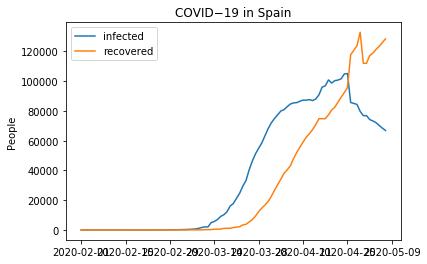

In [3]:
#Plotting real data:
plt.figure(1)
plt.plot(date,infected,label='infected')
plt.plot(date,recovered,label='recovered')
plt.title('COVID−19 in Spain')
plt.ylabel('People')
plt.legend(loc = 'best')
plt.show()

#### Scenario 1: estimating infection rate (r)
Sweep approach to find r and S0

In [4]:
def SIR(I_cond,dt,r,a):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - a*I0
    drdt = a*I0
    return dsdt,didt,drdt

def SEIR(I_cond,dt,r,a,ro):
    S0,I0,R0,E0 = I_cond
    dsdt = -r*S0*I0
    dedt = r*S0*I0 - ro*E0
    didt = ro*E0 -a*I0
    drdt = a*I0
    return dsdt,dedt,didt,drdt

In [5]:
#Caso SIR model sweep:
Ns = np.linspace(10.3**6,10.6**6,50)
Rs = np.linspace(0.545e-6,0.45e-6,50)

mse = []
for n in Ns:
    mse_n = []
    for r in Rs:
        I_cond = np.array([n,infected[0],recovered[0]])
        model_SIR = odeint(SIR,I_cond,dt,args = (r,a))
        mse_r=mean_squared_error(infected, model_SIR[:,1])
        #mse_r = np.sum((model_SIR[:,1]-infected)**2)/len(infected)
        mse_n.append(mse_r)
    for m in mse_n:
        mse.append(m)

best_fit = min(mse)
index = mse.index(best_fit)
Ns_index = int(index/50)
Rs_index = int(index/50)
print('Best fit: number of population'+' '+str(Ns[Ns_index])+', '+'value of r:'+' '+str(Rs[Rs_index]))

Best fit: number of population 1358966.691757, value of r: 4.7520408163265304e-07


Curve fitting approach to find r and S0

In [6]:
#Caso SIR model fitting
def SIR2(I_cond,dt,r):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0
    drdt = (1/2.3)*I0
    return dsdt,didt,drdt

def evolution_SIR(t,r,S0):
    return odeint(SIR2,[S0,1,0],t,args = (r,))[:,1]

In [7]:
params_SIR,params_covariance_SIR = curve_fit(evolution_SIR,dt,infected,[0.45e-6,1.4e6]) #Pillo los del sweep
r_value_SIR = params_SIR[0]
S0_value_SIR = params_SIR[1]
print('The value for r is equal to (SIR):',r_value_SIR)
print('The value for the initial susceptible population is (SIR):',S0_value_SIR)

The value for r is equal to (SIR): 2.2811369474341536e-07
The value for the initial susceptible population is (SIR): 2671886.500571174


#### Scenario 1: predicting when R0 becomes <1 and when the epidemic ends

In [8]:
#R0<1 and the end of the epidemic:
fit_SIR = evolution_SIR(dt,r_value_SIR,S0_value_SIR)
maximum = max(fit_SIR)
tmax = np.where(fit_SIR==maximum)
print('R_0<1:'+str(tmax[0]))

dt_extended = np.linspace(1,300,300)
fit_SIR_extended = evolution_SIR(dt_extended,r_value_SIR,S0_value_SIR)

fin_SIR = 0
cont = 0
for individual in fit_SIR_extended:
    if individual < 1:
        fin_SIR = cont + 2 #0-indexing
        break 
    else: 
        cont = cont+1
print('No more people will get infected after '+str(fin_SIR)+' days of epidemic.')

R_0<1:[76]
No more people will get infected after 172 days of epidemic.


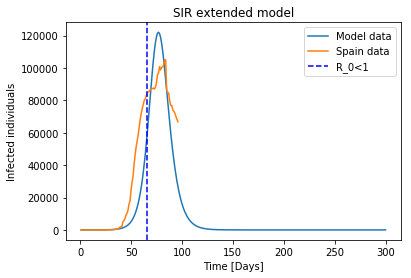

In [9]:
#Representación del resutlado:
plt.figure(1)
plt.plot(dt_extended,fit_SIR_extended,label='Model data')
plt.plot(dt,infected,label='Spain data')
plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()

#### Scenario 2: estimating the quarantine factor, q

In [32]:
#We consider the starting date of the confinment the day 43
day_conf=43
dt_pre_conf=np.linspace(1,day_conf,day_conf)
infected_pre_conf=list(infected[0:day_conf])

#r_value_SIR_pre = r_value_SIR 
#S0_value_SIR_pre = S0_value_SIR 
#print('The value for r before confinment is equal to (SIR):',r_value_SIR)
#print('The value for the initial susceptible population before confinment is (SIR):',S0_value_SIR)

results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
S, I, R = results_pre.T
S_new=S[-1]
I_new=I[-1]
R_new=R[-1]
print('The intial conditions for the confinment are S0 = ',S[-1],', I0 = ',I[-1],', R0 = ',R[-1])

The intial conditions for the confinment are S0 =  2666550.373873703 , I0 =  1526.7933921706126 , R0 =  3810.333305299144


In [33]:
#Caso SIR model fitting durante la cuarentena
def SIR_conf(I_cond,dt,r,q):
    S0,I0,R0 = I_cond
    dsdt = -r*S0*I0
    didt = r*S0*I0 - (1/2.3)*I0-q*I0
    drdt = (1/2.3)*I0+q*I0
    return dsdt,didt,drdt

def evolution_SIR_conf(t,q):
    return odeint(SIR_conf,[S_new,I_new,R_new],t,args = (r_value_SIR,q))[:,1]

Encontrar rango de q con sweep

In [34]:
dt_conf = np.linspace(1,len(infected)-day_conf,len(infected)-day_conf)
infected_conf = infected[day_conf:]
q_sweep = np.linspace(1e-2,1e-1,50)


mse_c = []
for q in q_sweep:
    model_SIR_conf = odeint(SIR_conf,[S_new,I_new,R_new],dt_conf,args = (r_value_SIR,q))
    S, I, R = model_SIR_conf.T
    #mse_r = np.sum((I-infected_conf)**2)/len(infected_conf)
    mse_r=mean_squared_error(infected_conf, I)
    mse_c.append(mse_r)
        
best_fit = min(mse_c)
index = mse_c.index(best_fit)
q_sweep_index = int(index/50)
#print(mse_c)
print('Best fit: number of q'+' '+str(q_sweep[q_sweep_index]))

Best fit: number of q 0.01


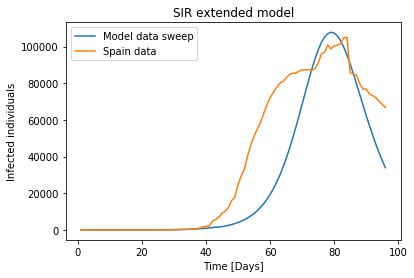

In [35]:
#Representación del resutlado:
q=q_sweep[q_sweep_index]


sweep_SIR_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q))
#sweep_SIR_conf=odeint(SIR2,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,))
S_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SIR_conf.T

I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data sweep')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)

Encontrar q con curve_fit

In [36]:
params_SIR_conf,params_covariance_SIR_conf = curve_fit(evolution_SIR_conf,dt[day_conf:],infected_conf,1e-2) 
q_value_SIR_conf = params_SIR_conf

print('The value for q is equal to:',q_value_SIR_conf)

The value for q is equal to: [0.00262797]


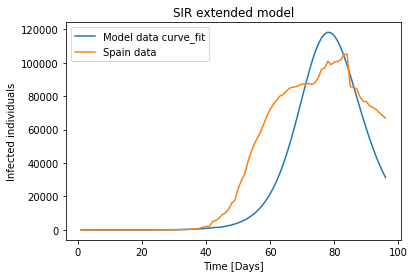

In [37]:
#Representación del resutlado:
q_value=q_value_SIR_conf


sweep_SIR_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,q_value))
#sweep_SIR_conf=odeint(SIR2,[S_new,I_new,R_new],dt[day_conf:],args = (r_value_SIR,))
S_sweep_conf, I_sweep_conf, R_sweep_conf = sweep_SIR_conf.T

I_conf=list(fit_SIR_extended[0:day_conf])
I_conf.extend(I_sweep_conf)

plt.figure(1)
plt.plot(dt,I_conf,label='Model data curve_fit')
plt.plot(dt,infected,label='Spain data')
#plt.axvline(66,color='blue',linestyle= 'dashed',label='R_0<1')

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
#print(I_conf)

#### Scenario 2: studying the effect of the starting date of confinment

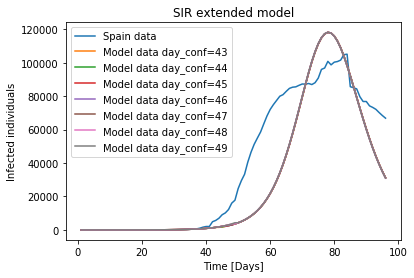

,Day of confinment,I_max,When R0 becomes <1
0,43,118219.0,[77]
1,44,118228.0,[77]
2,45,118237.0,[77]
3,46,118247.0,[77]
4,47,118258.0,[77]
5,48,118271.0,[77]
6,49,118284.0,[77]


In [47]:
day_conf=[43,44,45,46,47,48,49] #studying 7 days
plt.figure(1)
plt.plot(dt,infected,label='Spain data')
I_max_bis=[]
day_max_bis=[]
for d in day_conf:
    dt_pre_conf=np.linspace(1,d,d)
    infected_pre_conf=list(infected[0:d])
    #before
    results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
    S, I, R = results_pre.T
    S_new=S[-1]
    I_new=I[-1]
    R_new=R[-1]
    #after
    SIR_results_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[d:],args = (r_value_SIR,q_value))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    I_conf_total=list(fit_SIR_extended[0:d])
    I_conf_total.extend(I_conf)
    I_max_bis.append(round(max(I_conf_total)))
    day_max_bis.append(np.where(I_conf_total==max(I_conf_total))[0])  
    #plot
    plt.plot(dt,I_conf_total,label='Model data day_conf={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
plt.show()
data = {'Day of confinment': day_conf, 'I_max': I_max_bis, "When R0 becomes <1": day_max_bis }
df = pd.DataFrame(data=data)
df

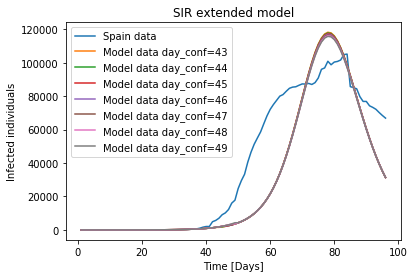

,Day of confinment,q,I_max,When R0 becomes <1
0,43,0.002628,118219.0,[77]
1,44,0.002895,117834.0,[77]
2,45,0.003172,117438.0,[77]
3,46,0.003459,117030.0,[77]
4,47,0.003757,116613.0,[77]
5,48,0.004064,116187.0,[77]
6,49,0.004382,115754.0,[77]


In [46]:
day_conf=[43,44,45,46,47,48,49] #studying 7 days
plt.figure(1)
plt.plot(dt,infected,label='Spain data')
q_list=[]
I_max=[]
day_max=[]
for d in day_conf:
    dt_pre_conf=np.linspace(1,d,d)
    infected_pre_conf=list(infected[0:d])
    #before
    results_pre = odeint(SIR2,[S0_value_SIR ,1,0],dt_pre_conf,args = (r_value_SIR,))
    S, I, R = results_pre.T
    S_new=S[-1]
    I_new=I[-1]
    R_new=R[-1]
    #after
    infected_conf = infected[d:]
    params_SIR_conf,params_covariance_SIR_conf = curve_fit(evolution_SIR_conf,dt[d:],infected_conf,1e-2) 
    q = params_SIR_conf
    q_list.append(float(q))
    SIR_results_conf=odeint(SIR_conf,[S_new,I_new,R_new],dt[d:],args = (r_value_SIR,q))
    S_conf, I_conf, R_conf = SIR_results_conf.T
    I_conf_total=list(fit_SIR_extended[0:d])
    I_conf_total.extend(I_conf)
    I_max.append(round(max(I_conf_total)))
    day_max.append(np.where(I_conf_total==max(I_conf_total))[0])  
    
    #plot
    plt.plot(dt,I_conf_total,label='Model data day_conf={}'.format(d))

plt.xlabel('Time [Days]')
plt.ylabel('Infected individuals')
plt.title('SIR extended model')
plt.legend(loc='best')
plt.show()
data = {'Day of confinment': day_conf, 'q': q_list,'I_max': I_max, "When R0 becomes <1": day_max}
df = pd.DataFrame(data=data)
df